# Running the entailment methods on the full dataset

This notebook takes the lessons from the `comparing_entailment_methods.ipynb` notebook and runs the final entailment methods on the full dataset to generate metrics for the different LLM models.

In [1]:
import pandas as pd
import numpy as np
import os
import json
from tqdm import tqdm
import ast
from dotenv import load_dotenv
load_dotenv()

from pydantic import BaseModel
import json

import openai
client = openai.OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

In [2]:
from src.entailment import entailment_from_gpt_json, process_entailment_result


In [3]:
df_questions = pd.read_csv('data/habermas_machine_questions_with_responses.csv')
df_questions['own_opinion.text'] = df_questions['own_opinion.text'].apply(ast.literal_eval)
df_questions.head()

,question.text,own_opinion.text,question_topic,question_id,gpt-3.5-turbo,gpt-4o,gemini-1.5-flash-002,llama-3.1-8B,gemma-2b,mistral-7B
0,Are people who hold high political office and ...,[One minute I think they should disclose and t...,74,15,There is no universal ethical requirement for ...,The ethical requirement for individuals in hig...,There's no universally agreed-upon ethical sta...,The requirement for public officials to disclo...,\n\nThis question is complex and there is no e...,\n\n[INST] Are people who hold high political ...
1,Are the NHS and the UK welfare state fit for p...,[The NHS and Welfare are not working how they ...,51,19,This is a complex question that can have diffe...,The National Health Service (NHS) and the wide...,"Whether the NHS and the UK welfare state are ""...",The NHS and the UK welfare state are complex s...,The UK's National Health Service (NHS) and its...,"\n\nThe NHS is a national treasure, but it is ..."
2,Are there any limits on what can be allowed to...,[We have to keep in mind some kind of decency ...,52,34,"Yes, there are regulations and guidelines set ...","Yes, there are several limits and regulations ...","Yes, there are many limits on what can be broa...","Yes, there are limits on what can be allowed t...","Yes, there are many limits on what can be allo...",\n\n[INST] What are the limits on what can be ...
3,Are there any questions that we should never a...,[I cannot think of a topic which would fall in...,14,36,"There are certain topics that can be harmful, ...",The idea of restricting discussion or voting o...,There's no universally agreed-upon list of top...,While it's essential to maintain an open and i...,"Sure, there are certain questions that should ...",\n\n[INST] Are there any questions that we sho...
4,Are there limits to how much tax people should...,[I think there are limits for poorer people to...,52,37,There is debate and varying opinions on what c...,The question of whether there should be limits...,There's no universally agreed-upon limit to ho...,The concept of tax limits is a complex and deb...,"Sure, there are limits to how much tax people ...",\n\n[INST] What is the best way to raise money...


In [6]:
# You should make sure these models are up to date before running this.
response_models = ['gpt-3.5-turbo', 'gpt-4o', 'llama-3.1-8B', 'mistral-7B'] 
assert all([model in df_questions.columns for model in response_models]) # Quick check

In [7]:
entailment_model= 'gpt-4o-mini'
entailment_results = []
for _, row in tqdm(df_questions.iterrows(), total=df_questions.shape[0], desc="Questions", leave=True):
    question = row['question.text']
    question_id = row['question_id']
    opinions = row['own_opinion.text']
    with tqdm(total=len(opinions), desc="Opinions", leave=False) as opinion_bar:
        for opinion_idx, opinion in enumerate(opinions):
            # with tqdm(total=len(response_models), desc="Response Models", leave=False) as response_bar:
            for response_model in response_models:
                response = row[response_model]
                entailment_result = entailment_from_gpt_json(question, response, opinion, model='gpt-4o-mini')
                matches = process_entailment_result(entailment_result, response)
                entailment_results.append({
                    'question_id': question_id,
                    'opinion_idx': opinion_idx,
                    'response_model': response_model,
                    'entailment_model': entailment_model,
                    'entailment_result': entailment_result,
                    'matches': matches
                })
                # response_bar.update(1)
            opinion_bar.update(1)


Questions:  11%|█         | 11/100 [18:46<2:31:52, 102.39s/it]


JSONDecodeError: Unterminated string starting at: line 1 column 89332 (char 89331)

In [8]:
raw_entailment_results = pd.DataFrame(entailment_results)
raw_entailment_results.to_csv('data/raw_entailment_results.csv', index=False)
raw_entailment_results.head()

,question_id,opinion_idx,response_model,entailment_model,entailment_result,matches
0,430,0,gpt-3.5-turbo,gpt-4o-mini,"{'steps': [{'step_number': 1, 'concept': 'Cann...","[(0, 57), (58, 263), (182, 263)]"
1,430,0,gpt-4o,gpt-4o-mini,"{'steps': [{'step_number': 1, 'concept': 'Lega...","[(24, 75), (331, 411), (291, 379), (403, 411)]"
2,430,0,llama-3.1-8B,gpt-4o-mini,"{'steps': [{'step_number': 1, 'concept': 'Lega...","[(0, 113), (196, 353), (521, 645), (994, 1133)..."
3,430,0,mistral-7B,gpt-4o-mini,"{'steps': [{'step_number': 1, 'concept': 'Lega...","[(1000, 1042), (1068, 1115), (601, 615), (1130..."
4,430,1,gpt-3.5-turbo,gpt-4o-mini,"{'steps': [{'step_number': 1, 'concept': 'Cann...","[(0, 57), (58, 263), (264, 480)]"


## Generating metrics

Here we're going to generate a sample of metrics over the entailment results for each of the models.

In [11]:
raw_entailment_results['match_total_length'] = raw_entailment_results['matches'].apply(
    lambda x: sum([match[1]-match[0] for match in x])
)

In [24]:
raw_entailment_results['question_length'] = raw_entailment_results['question_id'].map(df_questions.set_index('question_id')['question.text'].str.len())
raw_entailment_results['match_length_ratio'] = raw_entailment_results['match_total_length'] / raw_entailment_results['question_length']

In [28]:
raw_entailment_results.groupby(['response_model'])['match_length_ratio'].mean()

response_model
gpt-3.5-turbo    4.708167
gpt-4o           6.031645
llama-3.1-8B     7.440795
mistral-7B       2.956597
Name: match_length_ratio, dtype: float64

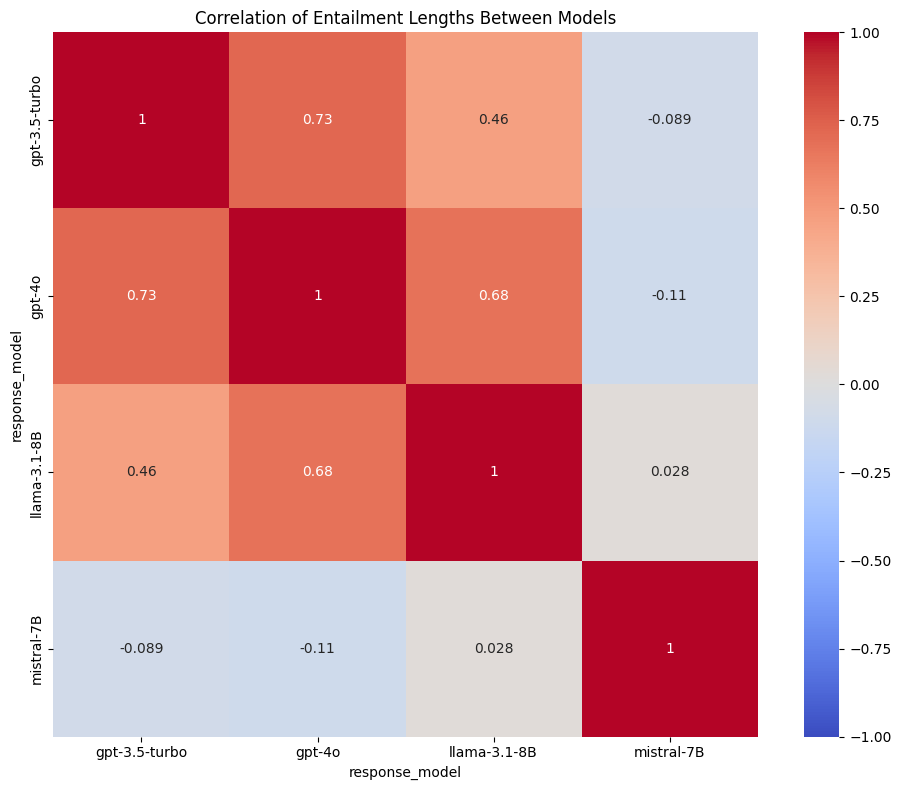

In [29]:
# Now seaborn heatmap plot the correlation between the entailment length correlation across pairs of models
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the data to create a matrix of match lengths by question/opinion and model
pivot_df = raw_entailment_results.pivot_table(
    index=['question_id', 'opinion_idx'],
    columns='response_model',
    values='match_length_ratio'
)

# Calculate correlation matrix
corr_matrix = pivot_df.corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,  # Show correlation values
    cmap='coolwarm',  # Color scheme
    vmin=-1, vmax=1,  # Force scale from -1 to 1
    center=0,  # Center the colormap at 0
    square=True  # Make cells square
)
plt.title('Correlation of Entailment Lengths Between Models')
plt.tight_layout()
plt.show()